In [1]:
import pandas as pd
import io
import numpy as np
import pymc3 as pm

from sklearn.preprocessing import StandardScaler


In [2]:
with open('german.data', 'r') as f:
    data_str = f.read()


In [3]:
# reading file 
data = io.StringIO(data_str)
df = pd.read_csv(data,sep=' ', header=None)
df.columns = ['status', 'months', 'credit', 'purpose', 'amount', 'savings', 'employment', 'rate', 'sex', 'other', 'residence',
            'property', 'age', 'plan', 'housing', 'nb_credits', 'job', 'liability', 'phone', 'foreign', 'target']
df.loc[df['target']==1, 'target'] =0
df.loc[df['target']==2, 'target'] =1

# replace categories by integers
std_scaler = StandardScaler()

for c in df.columns[:-1]:
    if df[c].dtype != np.int64:
        # convert to categorical
        df[c] = df[c].astype('category').cat.codes
    else:
        # normalize
        df[c] = (df[c] -df[c].mean())/df[c].std()

df.head()

,status,months,credit,purpose,amount,savings,employment,rate,sex,other,...,property,age,plan,housing,nb_credits,job,liability,phone,foreign,target
0,0,-1.235859,4,4,-0.744759,4,4,0.918018,2,0,...,0,2.765073,2,1,1.026565,2,-0.428075,1,0,0
1,1,2.247070,2,4,0.949342,0,2,-0.869748,1,0,...,0,-1.190808,2,1,-0.704573,2,-0.428075,0,0,1
2,3,-0.738298,4,7,-0.416354,0,3,-0.869748,2,0,...,0,1.182721,2,1,-0.704573,1,2.333701,0,0,0
3,0,1.749509,2,3,1.633430,0,3,-0.869748,2,2,...,1,0.831087,2,2,-0.704573,2,2.333701,0,0,0
4,0,0.256825,3,0,0.566380,0,2,0.024135,2,0,...,3,1.534354,2,2,1.026565,2,2.333701,0,0,1


In [4]:
df.iloc[:,:-1].shape

(1000, 20)

In [5]:
df.columns

Index(['status', 'months', 'credit', 'purpose', 'amount', 'savings',
       'employment', 'rate', 'sex', 'other', 'residence', 'property', 'age',
       'plan', 'housing', 'nb_credits', 'job', 'liability', 'phone', 'foreign',
       'target'],
      dtype='object')

Here $Y_i$ is a discrete RV that can take two values 0 and 1. Thus the Bernouilli probability model is the best candidate for the data. If we note $\pi_i$ the probability of accepting the credit for an individual $i$, 
    $$Y_i|\pi_i \sim Bern(\pi_i)$$
    and the expected value is:
    $$E(Y_i|\pi_i)=\pi$$

Finally we can define a linear model where $X_i \in \mathbb{R}^d$ describes the features of an individual $i$ with, $\alpha \in \mathbb{R}$, the intercept and $\beta \in \mathbb{R}^d$ the vector of coefficients:
$$g(\pi_i) = \alpha + \beta X_i$$
Now our goal is to write the Bernouilli mean $\pi_i$ as a linear function of $\alpha, \beta$. We can assume $\pi_i$ depends on the features $X_i$ through the logit function.  Hence :
$$\frac{\pi_i}{1 - \pi_i} = e^{\alpha + \beta X_i}$$ 
and
$$\pi_i = \frac{e^{\alpha + \beta X_i}}{1 + e^{\alpha + \beta X_i}}$$

To complete the Bayesian logistic regression model we need to specify priors on our regression parameters. Here we use zero-mean normal priors with variance $\sigma^2 = 100$. This is a weak prior because a large variance specifies little information about the parameter. 

We can now use an MCMC method to approximate the posterior.


In [4]:
# initialise using MLE 
from sklearn.linear_model import LogisticRegression
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X, y = X.to_numpy(), y.to_numpy()

lr = LogisticRegression()
lr.fit(X,y)
alpha = lr.intercept_
betas = lr.coef_

coefs = np.empty((21))
coefs[0] = alpha
coefs[1:]=betas

# add column of ones to make computation ez 
X = np.hstack((np.ones((1000,1)), X))



In [5]:
import jax.numpy as jnp 
from jax import grad

mu = 0
var = 100
def log_posterior_param(X, y, betas, mu, var):
    # likelihood x prior
    # we append to X a column of ones at the beginning
    prob = jnp.exp(betas@X.T) / (1 + jnp.exp(betas@X.T) )
    like = jnp.sum(y * jnp.log(prob) + (1-y) * jnp.log(1-prob))
    prior = jnp.sum(jnp.log(1/jnp.sqrt(2*jnp.pi*var)) - 0.5 * ((betas -mu)**2 / var))
    return like + prior 


def log_posterior(betas):
    return log_posterior_param(X, y, betas, mu, var)

grad_logp = grad(log_posterior)





In [28]:
# function to plot distributions
import matplotlib.pyplot as plt 
def plot_sampler(samples):
    samples = np.array(samples)
    fig, axs = plt.subplots(4,5, figsize=(15,12))
    n = 0
    for i in range(4):
        for row in range(5):
            axs[i,row].plot(samples[:,n])
            axs[i,row].set_ylabel('Coefficient {}'.format(n))
            axs[i,row].set_xlabel('Number of steps')
            n += 1 

    return fig



Example of Sampling using HMC where we noticed epislon required tuning otherwise the leapfrog integrator would quickly diverge.

/home/joseph/Documents/m2/bayes/No-U-Turn-Sampler/hmc.py:39: RuntimeWarning: invalid value encountered in float_scalars
  alpha = min(1, np.exp(self.logp(theta_tilde) -
/tmp/ipykernel_10724/174881897.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


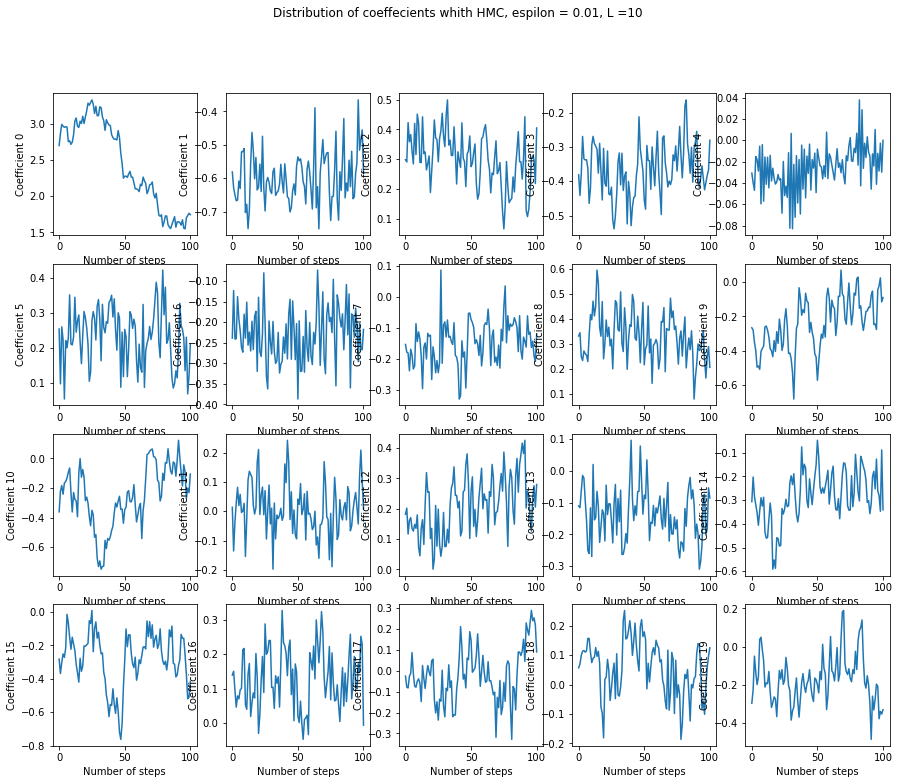

In [29]:
from hmc import HamiltonianMonteCarlo
eps, L = 0.01, 10 # sampler
seed = 1
sampler = HamiltonianMonteCarlo(eps=eps, L=L, 
                                logp=log_posterior, grad_logp=grad_logp,
                                num_iterations=100,
                                seed=seed)
samples = sampler.run(coefs)

fig = plot_sampler(samples)

fig.suptitle('Distribution of coeffecients whith HMC, espilon = 0.01, L =10')

fig.show()


/home/joseph/Documents/m2/bayes/No-U-Turn-Sampler/nuts.py:169: RuntimeWarning: overflow encountered in exp
  s_prime = 1 if u < np.exp(NaiveNUTS.DELTAMAX +
/tmp/ipykernel_10724/1906997163.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


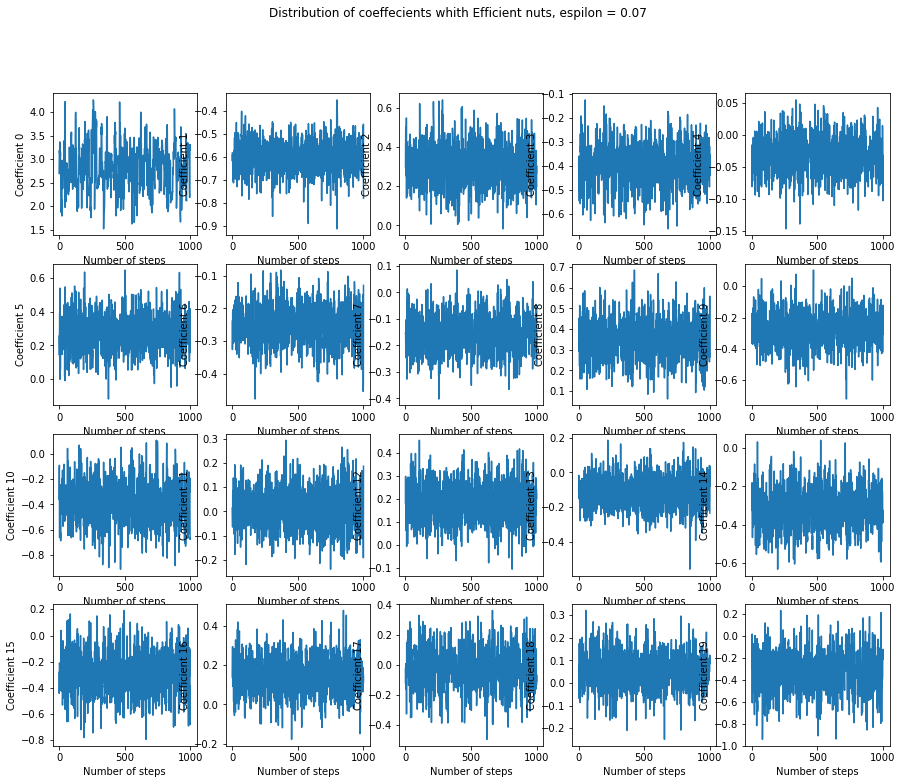

In [39]:
from nuts import EfficientNUTS
eps = 0.01 # sampler
seed = 1
sampler = EfficientNUTS(eps=eps, 
                        logp=log_posterior, grad_logp=grad_logp,
                        num_iterations=1000,
                        seed=seed)

samples = sampler.run(coefs)

fig = plot_sampler(samples)

fig.suptitle('Distribution of coeffecients whith Efficient nuts, espilon = 0.07')

fig.show()


In [38]:
len(samples)

1001

In [41]:
samples = np.array(samples)

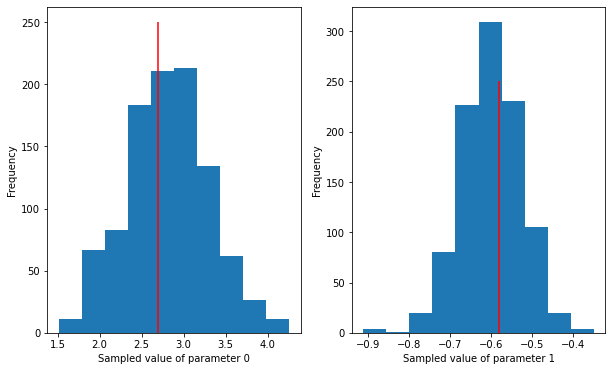

In [44]:
fig, axs = plt.subplots(1,2, figsize=(10,6))

for i in range(2):
    axs[i].hist(samples[:,i])
    axs[i].vlines(coefs[i], 0, 250,color='red')
    axs[i].set_xlabel('Sampled value of parameter '+str(i))
    axs[i].set_ylabel('Frequency')



In [45]:
def make_prediction(coefs):
    
    prod = np.exp(coefs@X.T) / (1 + np.exp(coefs@X.T) )

    y_hat = np.zeros(prod.shape)
    y_hat[prod < 0.5] = 1
    

    return y_hat
    



In [46]:
# evaluate model 
from sklearn.metrics import accuracy_score
samples = np.array(samples)
score = []
for i in range(samples.shape[0]):
    coefs = samples[i]
    y_hat  = make_prediction(coefs)
    score.append(accuracy_score(y, y_hat))



We know what to select the final coefficients for our model 

Text(0, 0.5, 'Accuracy')

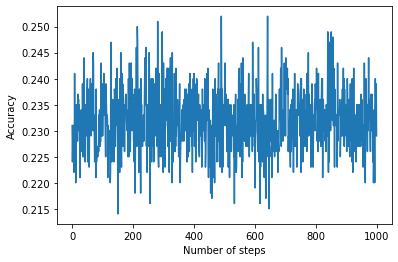

In [47]:
fig, ax = plt.subplots()

ax.plot(score)
ax.set_xlabel('Number of steps')
ax.set_ylabel('Accuracy')